In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F 
from torchvision import datasets, transforms
import os

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
train_dir = "CustomDataset/train"
test_dir = "CustomDataset/test"

In [4]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

In [5]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

In [6]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [7]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
from modelarch import CustomCNN

model_1 = CustomCNN(num_classes=7)
model_1.to(device)

CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=25

In [9]:
class_names = train_data.classes
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
len(train_data), len(test_data)

(28709, 7178)

In [11]:
from torchinfo import summary

summary(model=model_1,
        input_size=(32,1,48,48),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device=str(device)  # Ensure summary runs on the same device as the model
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomCNN (CustomCNN)                    [32, 1, 48, 48]      [32, 7]              --                   True
├─Conv2d (conv1)                         [32, 1, 48, 48]      [32, 32, 48, 48]     320                  True
├─BatchNorm2d (bn1)                      [32, 32, 48, 48]     [32, 32, 48, 48]     64                   True
├─ReLU (relu)                            [32, 32, 48, 48]     [32, 32, 48, 48]     --                   --
├─Conv2d (conv2)                         [32, 32, 48, 48]     [32, 64, 48, 48]     18,496               True
├─BatchNorm2d (bn2)                      [32, 64, 48, 48]     [32, 64, 48, 48]     128                  True
├─ReLU (relu)                            [32, 64, 48, 48]     [32, 64, 48, 48]     --                   --
├─MaxPool2d (pool)                       [32, 64, 48, 48]     [32, 64, 24, 24]     --                   --
├─Conv2d (conv3)    

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001, weight_decay=1e-4)

In [13]:
from trainNN import train

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()


In [14]:
# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Print shape of images
print(images.shape)  # Output: [batch_size, channels, height, width]


torch.Size([32, 1, 48, 48])


In [24]:
results = train(
            model=model_1,
            train_dataloader=train_loader,
            test_dataloader=test_loader,
            optimizer=optimizer,
            loss_fn=criterion,
            epochs=30,
            device=device
)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9415 | train_acc: 0.6472 | test_loss: 0.9363 | test_acc: 0.6539
Epoch: 2 | train_loss: 0.9417 | train_acc: 0.6490 | test_loss: 0.9362 | test_acc: 0.6491
Epoch: 3 | train_loss: 0.9413 | train_acc: 0.6478 | test_loss: 0.9462 | test_acc: 0.6551
Epoch: 4 | train_loss: 0.9394 | train_acc: 0.6461 | test_loss: 0.9379 | test_acc: 0.6572
Epoch: 5 | train_loss: 0.9389 | train_acc: 0.6471 | test_loss: 0.9599 | test_acc: 0.6451
Epoch: 6 | train_loss: 0.9430 | train_acc: 0.6461 | test_loss: 0.9497 | test_acc: 0.6471
Epoch: 7 | train_loss: 0.9388 | train_acc: 0.6491 | test_loss: 0.9569 | test_acc: 0.6504
Epoch: 8 | train_loss: 0.9398 | train_acc: 0.6461 | test_loss: 0.9393 | test_acc: 0.6511
Epoch: 9 | train_loss: 0.9388 | train_acc: 0.6486 | test_loss: 0.9493 | test_acc: 0.6468
Epoch: 10 | train_loss: 0.9333 | train_acc: 0.6494 | test_loss: 0.9315 | test_acc: 0.6543
Epoch: 11 | train_loss: 0.9455 | train_acc: 0.6457 | test_loss: 0.9357 | test_acc: 0.6561
Epoch: 12 | train_l

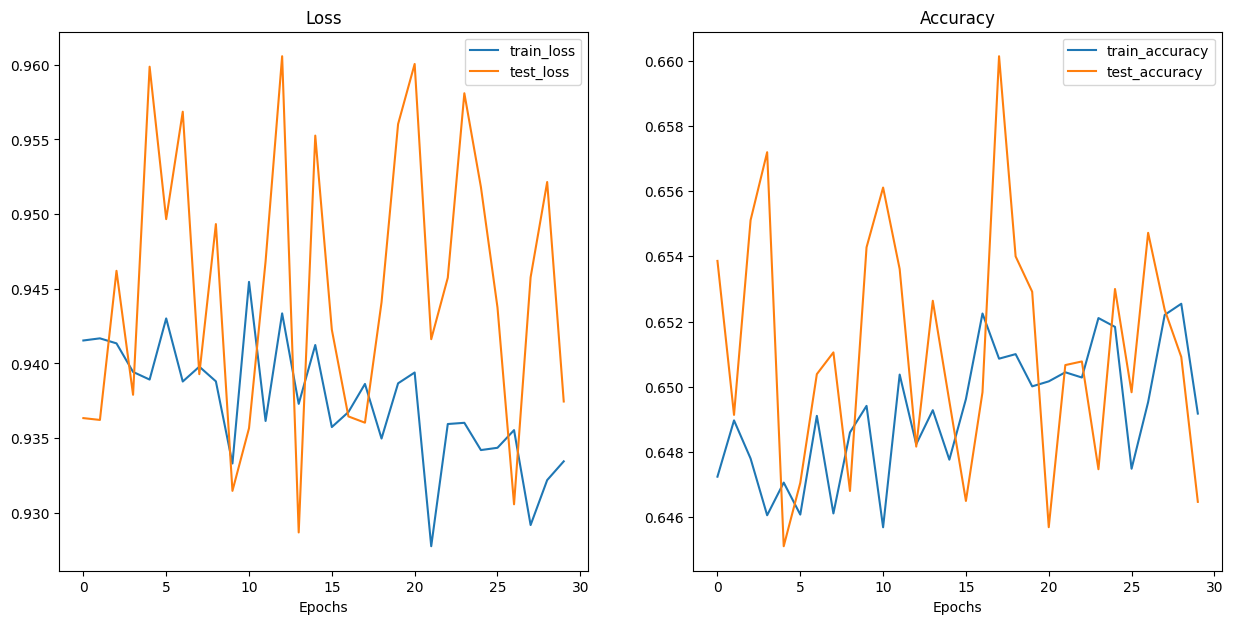

In [25]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [26]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "modeldrop4.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\modeldrop4.pth
